# Defining relevant functions


In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.stats import laplace, norm
from typing import Callable

In [2]:
def arbitrary_poly(params: list) -> Callable:
    """
    Takes the parameters in params and makes them into a polynomial 
        theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
    where n is model order and theta_0 is bias. 
    Args:
        params: list on format [theta_0, theta_1, theta_2, ..., theta_n]
    Returns:
        Function with single argument x. 
    """
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


In [3]:
class GaussParams:
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.var = std**2

        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.std

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.std))


class LaplaceParams:
    def __init__(self, mean: float, beta: float):
        self.mean = mean
        self.beta = beta
        
        # aliases, these are the names used in scipy.stats functions
        self.loc = self.mean
        self.scale = self.beta

    def __iter__(self):  # to allow tuple unpacking
        return iter((self.mean, self.beta))


In [4]:
def generate_noise(
        N: int, 
        magnitude: float, 
        alpha: float, 
        gauss_params: GaussParams, 
        laplace_params: LaplaceParams, 
        seed: int = None
    ) -> np.ndarray:
    """
    Generate noise based on the mixture model: alpha * gaussian + (1 - alpha) * laplacian.
    Args:
        N: number of noise points to generate.
        magnitude: the noise amplitude/magnitude.
        alpha: probabilty of guassian or laplacian, should be in interval [0, 1].
        gauss_params: mean and std of gaussian distribution
        laplace_params: mean and beta of laplacian distribution
        seed: a custom seed to the RNG. If None, the RNG is not seeded.
    Returns:
        A list of N noise points.
    """
    if seed is not None:
        np.random.seed(seed)

    if alpha == 1:
        assert gauss_params is not None
        noise = np.random.normal(*gauss_params, N)
    elif alpha == 0:
        assert laplace_params is not None
        noise = np.random.laplace(*laplace_params, N)
    else:
        assert gauss_params is not None
        assert laplace_params is not None
        assert 0 < alpha < 1
        noise = np.zeros((N,))
        for i in range(N):
            r = np.random.uniform(0,1)
            if r <= alpha:
                noise[i] = np.random.normal(*gauss_params)
            else:
                noise[i] = np.random.laplace(*laplace_params)
    noise *= magnitude

    return noise

In [5]:
def add_outliers(y: np.ndarray, gamma: float, outlier_ampl: float = 100, seed: int = None) -> np.ndarray:
    """
    Adds outliers to y with probabilty gamma.
    Args:
        y: an array of measurement values with or without noise, shape = (N,) or (N,1).
        gamma: probability of a specific measurement being an outlier.
        outlier_ampl: amplitude of outlier, default 100.
        seed: custom seed to RNG. If None, do not reseed RNG.
    Returns:
        y_outlier: an array of the same lengths as y, but with some added outliers.
    """
    if seed is not None:
        np.random.seed(seed)

    assert 0 <= gamma <= 1

    N = y.shape[0]
    y_outlier = np.copy(y)
    for i in range(N):
        r = np.random.uniform(0,1)
        if r <= gamma:
            y_outlier[i] = outlier_ampl

    return y_outlier


In [6]:
def least_square(u: np.ndarray, y: np.ndarray, n_params: int) -> np.ndarray:
    """
    Uses least sqaure (LS) to make the best fitting list of parameters.
    Args:
        u: data x values, shape = (N_samples,)
        y: data y values, shape = (N_samples,)
        n_params: number of parameters to find
    """
    N = u.shape[0]
    
    # Create data tensor
    u_tensor = np.ones((N,1))
    for i in range(1, n_params):
        u_tensor = np.append(u_tensor, np.power(u.reshape((-1,1)), i), axis=1)

    # Solve for LS params
    u_dot_u = u_tensor.T @ u_tensor
    u_dot_y = u_tensor.T @ y
    # linalg.solve is more numerically stable than linalg.inv and is therefore preferred
    ls_params = np.linalg.solve(u_dot_u, u_dot_y)

    return ls_params


In [7]:
def log_likelihood(params: np.ndarray, u: np.ndarray, y: np.ndarray, pdf: Callable) -> np.float:
    """
    Computes the log-likelihood of the pdf given the data u and y.
    Args:
        params: the parameters for the model.
        u: data points x value.
        y: measurement data.
        pdf: pdf function from scipy of desired distribution.
    Returns:
        The log-likelihood of the pdf evaluated at the data, or np.inf.
    """
    if params[-1] < 0: 
        # standard deviation is estimated and cannot be negative
        return np.inf
    
    lik = pdf(y, loc=arbitrary_poly(params[:-1])(u), scale=params[-1])
    
    # log(0) = -inf
    if np.all(lik == 0):
        return np.inf

    ll = -np.sum(np.log(lik[np.nonzero(lik)]))
    return ll


def maximum_likelihood(u: np.ndarray, y: np.ndarray, n_params: int, pdf: Callable, opt_disp: bool = False) -> np.ndarray:
    """
    Calculates the Maximum Likelihood estimate for a polynomial model with n_params parameters
    based on the given pdf.
    Args:
        u: data points x values, shape = (N,).
        y: measurement data, shape = (N,).
        n_params: the number of parameters in the model, including bias. 
                  theta_0 + theta_1*x + theta_2*x^2 + ... + theta_n*x^n
        pdf: pdf function from scipy of desired distribution.
        opt_disp: show output from optimization function, default False.
    Returns:
        List of parameters. 
    """
    assert len(u) == len(y)
    
    N = u.shape[0]
    init_guess = np.zeros((n_params + 1,))
    init_guess[-1] = N

    optres = optimize.minimize(
        fun=log_likelihood, x0=init_guess, args=(u, y, pdf), options={"disp": opt_disp}
    )

    ml_params = optres.x[:-1]
    return ml_params



In [8]:
def SAD(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate the sub of absolute deviation between outputs y for each u.
    Args:
        u: data points x value.
        y: measurement data.
        est_params: estimate parameters from the data.
    Returns:
        sad: the sum of absolute deviation.
    """
    assert len(u) == len(y)

    y_est = arbitrary_poly(est_params)(u)
    sad = np.sum(np.abs(y - y_est))

    return sad


def RSS(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Residual Sum of Sqaures.
    """
    assert len(u) == len(y)
    y_est = arbitrary_poly(est_params)(u)
    rss = np.sum((y - y_est)**2)
    return rss


def RMSE(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Root Mean Square Error.
    """
    assert len(u) == len(y)
    N = u.shape[0]
    rmse = np.sqrt( RSS(u, y, est_params) / N )
    return rmse


def MAD(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Mean Absolute Deviation.
    """
    # TODO: This is actually done ExpectedValue(abs(y-y_est)) which depends 
    # on the distribution. The way done below assumes centered and unskewed 
    # distribution (Gaussian, Laplacian, etc). How to do generally? 
    assert len(u) == len(y)
    y_est = arbitrary_poly(est_params)(u)
    N = u.shape[0]
    mad = np.mean(np.abs(y - y_est))
    return mad


def FVU(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Fraction of Variance Unexplained.
    """
    assert len(u) == len(y)
    rss = RSS(u, y, est_params)
    var = np.var(y)
    fvu = rss / var
    return fvu


def Rsquare(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate R^2.
    """
    r2 = 1 - FVU(u, y, est_params)
    return r2


def FIT(u: np.ndarray, y: np.ndarray, est_params: np.ndarray) -> float:
    """
    Calculate Fit. 
    """
    root_rss = np.sqrt(RSS(u, y, est_params))
    root_var = np.sqrt(np.var(y))
    fit = 100 * (1 - root_rss / root_var)
    # alternative:
    # fit = 100 * (1 - fvu)
    return fit


# Generate data 

In [9]:
# True model
true_params = [1,-8,4]
n_params = len(true_params)
y_model = arbitrary_poly(true_params)

# Hyperparameters for noise generation
magnitude = 1.2  # noise magnitude
N = 10          # number of samples

# Setup RNG
np.random.seed(0)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1

u = np.linspace(range_low, range_high, N)
y_true = y_model(u)

# Generate noise
noise = generate_noise(N, magnitude, 0, None, LaplaceParams(0, 1), seed=None)
y_noise = y_true + noise

y = y_noise

# Split into train, test and validate sets
M = N // 2  # size of each subset
u_train, y_train = u[0:M], y[0:M]
u_test, y_test = u[M:2*M], y[M:2*M]

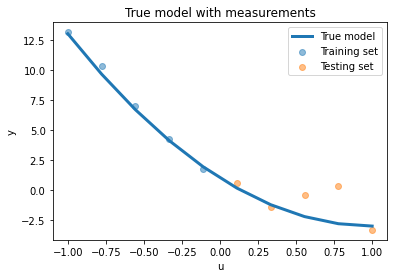

In [10]:
# Plot model and measurements
plt.figure()
plt.plot(u, y_model(u), lw=3, label="True model")
# plt.scatter(u, y_outlier, alpha=0.5, label="Measurements w/ outliers")
plt.scatter(u_train, y_train, alpha=0.5, label="Training set")
plt.scatter(u_test, y_test, alpha=0.5, label="Testing set")
plt.legend()
plt.xlabel("u")
plt.ylabel("y")
plt.title("True model with measurements")
plt.show()


# Train models of order 0-9


In [11]:
perf_data = np.zeros((10,7,4))
ls_params = []
ml_params = []

for i in range(10):
    n_params = i + 1

    ls = least_square(u_train, y_train, n_params)
    ml = maximum_likelihood(u_train, y_train, n_params, pdf=laplace.pdf, opt_disp=False)

    ls_params.append(ls)
    ml_params.append(ml)

    perf_ls_train = np.array((
        SAD(u_train, y_train, ls),
        RSS(u_train, y_train, ls),
        RMSE(u_train, y_train, ls),
        MAD(u_train, y_train, ls),
        FVU(u_train, y_train, ls),
        Rsquare(u_train, y_train, ls),
        FIT(u_train, y_train, ls)
    )).reshape((7,1))

    perf_ls_test = np.array((
        SAD(u_test, y_test, ls),
        RSS(u_test, y_test, ls),
        RMSE(u_test, y_test, ls),
        MAD(u_test, y_test, ls),
        FVU(u_test, y_test, ls),
        Rsquare(u_test, y_test, ls),
        FIT(u_test, y_test, ls)
    )).reshape((7,1))

    perf_ml_train = np.array((
        SAD(u_train, y_train, ml),
        RSS(u_train, y_train, ml),
        RMSE(u_train, y_train, ml),
        MAD(u_train, y_train, ml),
        FVU(u_train, y_train, ml),
        Rsquare(u_train, y_train, ml),
        FIT(u_train, y_train, ml)
    )).reshape((7,1))

    perf_ml_test = np.array((
        SAD(u_test, y_test, ml),
        RSS(u_test, y_test, ml),
        RMSE(u_test, y_test, ml),
        MAD(u_test, y_test, ml),
        FVU(u_test, y_test, ml),
        Rsquare(u_test, y_test, ml),
        FIT(u_test, y_test, ml)
    )).reshape((7,1))

    perf_data[i] = np.hstack((perf_ls_train, perf_ls_test, perf_ml_train, perf_ml_test))


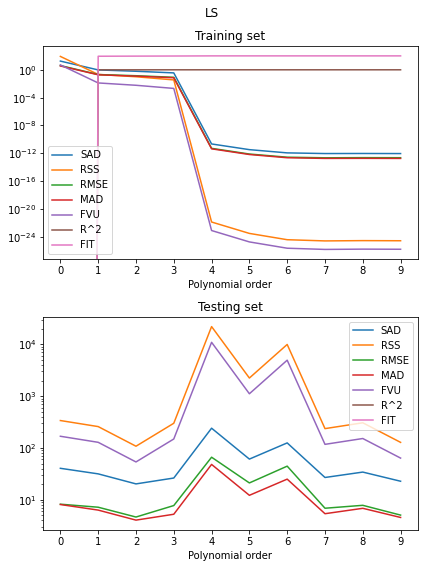

In [12]:
plt.figure(figsize=(6,8))
plt.suptitle("LS")

legends = ["SAD", "RSS", "RMSE", "MAD", "FVU", "R^2", "FIT"]

for perf_idx in range(7):
    plt.subplot(211)
    plt.semilogy(perf_data[:, perf_idx, 0], label=legends[perf_idx])
    plt.legend()
    plt.xlabel("Polynomial order")
    plt.xticks(ticks=range(10), labels=[str(n) for n in range(10)])
    plt.title("Training set")
    
    plt.subplot(212)
    plt.semilogy(perf_data[:, perf_idx, 1], label=legends[perf_idx])
    plt.legend()
    plt.xlabel("Polynomial order")
    plt.xticks(ticks=range(10), labels=[str(n) for n in range(10)])
    plt.title("Testing set")

plt.tight_layout()
plt.show()

    

## Comments on LS plots

_Note:_ The figures are on a semilogy plot, so the y-axis is logarithmic. This is because some values are really large, and plotting on logarithmic scale makes it easier to interpret.

For LS on the training set we see that as the model order increases, RSS, RMSE, MAD, and FVU decrease at the same rate. We also see an edge at polynormial order 4. This is because we only have 5 training points, and a polynomial of order 4 will perfectly model those 5 points. However, beyond this point the model perfectly match the training data, and is overfitted. One could also argue that the model is overfitting at 4th order, however, it is hard to make a more precise comment due to the small dataset. After polynomial order 1, the $R^2$ and FIT metrics go to $0.987$ and $88.6\%$, respectively. These values are very high and indicate a good model fit for our data. This can be understood by looking at the plot of the data. The training set is in a region of the curve that is close to linear, so it is reasonable that we will get a good model for that part of the data. 

Looking at LS on the test set is an entirely different story. This is previously unseen data so it is expected to perform worse. $R^2$ and FIT are negative and does not show up on the semilogy plot. This is an indication of a bad fit. We also see the error increase after polynomial order 4, and stays high. This also confirms the overfitting discussed above. We also see that the error decrease as the polynomial order goes from 0 to 2. This indicates that the model is underfitting for lower polynomial orders (0 and 1 at least). If we look at the plot of the data, we see that the training set is almost linear, while the test set is more quadratic. So when training it is not incorrect to think we have a linear model, but this shows looking at training data alone is not enough, and that we need the testing data to see how our model performs on unseen data. From the two plots, one could conclude that a order 2 polynomial is the model order of the data. 

Simpler models have high bias and low variance, while more complex models have small bias and high variance. The polynomial of order 0 have high bias, while the polynomial of order 4 has high variance. The low order polynomial struggle to capture the complexities of the data, while the high order polynomial captures them "too well". However, if we change some data points the high order model will have a relatively higher change is performance indices as it goes from $\approx 0$ (perfect fit) to $\neq 0$. On the other hand, the low order model will not fit the data well and hence not give very good predictions, but will also not change its predictions much when the data points change slightly. Thus we say it has low variance. To quote StatQuest on YouTube: "The straight line might only give good predictions, and not great predictions. But they willl be consistently good predictions." (https://www.youtube.com/watch?v=EuBBz3bI-aA, 5:04). To select the best model, we need to make a trade-off between bias and variance. Based on the discussion above, we could reach the same conclusion of polynomial order 2. 



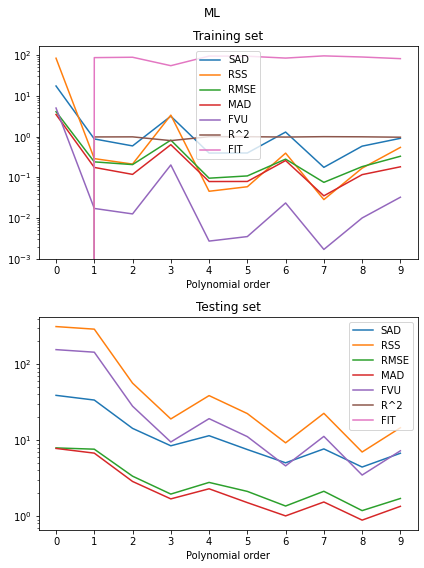

In [13]:
plt.figure(figsize=(6,8))
plt.suptitle("ML")

legends = ["SAD", "RSS", "RMSE", "MAD", "FVU", "R^2", "FIT"]

for perf_idx in range(7):
    plt.subplot(211)
    plt.semilogy(perf_data[:, perf_idx, 2], label=legends[perf_idx])
    plt.legend()
    plt.xlabel("Polynomial order")
    plt.xticks(ticks=range(10), labels=[str(n) for n in range(10)])
    plt.title("Training set")
    
    plt.subplot(212)
    plt.semilogy(perf_data[:, perf_idx, 3], label=legends[perf_idx])
    plt.legend()
    plt.xlabel("Polynomial order")
    plt.xticks(ticks=range(10), labels=[str(n) for n in range(10)])
    plt.title("Testing set")

plt.tight_layout()
plt.show()

## Comments on ML plots

The ML estimator takes into account the distribution of the noise and gives the most likely parameters (hence the name). Therefore, we will not see the same type of overfitting at polynomial order 4 as we did for the LS estimator. We also see that the difference between the training and testing set is not as large as for LS. However, I would still claim there is some overfitting happening here. We also see that the FIT and $R^2$ go from very low to almost perfect at polynomial order 1 for the training set, same as the LS. However, there is some more variablitiy in these performance indices than for LS. Somewhat surprisingly, the testing data seem to continue to improve as the polynomial order increase. There is some variablitiy, but there is a global minimum at polynomial order 8. For the training set this global minimum is at order 7. The conclusion about which order to choose is not as clear here as for LS. There is also not as clear bias vs. variance trade-off here as for LS. The ML estimates seem to be close in terms of bias and variance for most polynomial orders above 2. However, there is some interesting spikes at 3 and 6 which I do not have any good explaination for. 
